# This notebook reconstructs buffers to create additional data
## Ethnologue data cannot be shared freely due to copyright issues

# Setup

In [1]:
#%%px --local
#!/usr/bin/env python
# coding: utf-8
'''
======================================================
Author:  Ömer Özak, 2014 (ozak at smu.edu)
Website: http://omerozak.com
GitHub:  https://github.com/ozak/
======================================================
Construct Fishnet of size X
'''
#from __future__ import division
# Parallel
#try:
#    from ipyparallel import Client
#except:
#    from IPython.parallel import Client

## Setup the clients, direct views, and balanced views
#c = Client()
#c.ids
#dview = c[:]
#view = c.load_balanced_view()
#dview.activate()

import sys, os, time
import matplotlib.pyplot as plt
# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

#import pandas.tools.util as tools
# GIS packages
os.environ['USE_PYGEOS'] = '0'
#from osgeo import  ogr, osr, gdal, gdalnumeric
#from gdalconst import *
#from PIL import Image, ImageDraw
#from pyGDsandbox.dataIO import df2dbf, dbf2df
#from rasterstats import zonal_stats
#import shutil, glob
#import pysal as ps
#from pysal.contrib import shapely_ext
#import shapely
from shapely.geometry import Polygon, Point
#from shapely.wkt import loads, dumps
#from shapely.ops import cascaded_union
import pyproj
import georasters as gr
#import hmi
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas
#from geopandas.tools import sjoin
#from geopy.distance import great_circle
#import geostats

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# File packages
#import tarfile
#import gzip

# Graph packages
#import skimage.graph as graph
#from skimage.morphology import watershed
#import networkx as nx

# Econometrics
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from patsy import dmatrices

# Various other packages
#from rtree import index     # Indices
#import difflib              # Match text
import isounidecode         # Decode and encode text
#from collections import OrderedDict
import itertools
from functools import reduce

# Paths
path = './'
proot = '../../data/'
pathout = proot + 'Ethnologue/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.
pathdickens = proot + '../Dickens-EJ-2021/ueab065_replication_files/'
pathstats = proot + 'stats/'
pathgraphs = '../../graphs/'

if not os.path.exists(pathout):
    os.mkdir(pathout)

if not os.path.exists(pathstats):
    os.mkdir(pathstats)

if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

In [2]:
# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [3]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [4]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

## Set up the buffer size **RADIUS** in Kilometer in the cell below (The default is 50km radius)

In [5]:
buffer_size_radius_km = 50

<div class="alert alert-block alert-info", >
    <center><H1>Using Original Data</H1>
</div>

# Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

## Main original replication data file with all pairwise data based on buffers of 50kms

In [6]:
dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_2027644/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [7]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [8]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [9]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [10]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


# Shapefiles for figure 1, which shows the buffer construction

In [11]:
africa_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Africa_Country_Borders.shp')
border_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Border.shp')
manyika_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Manyika.shp')
shona_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona.shp')
buffer_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona_Manyika_Buffer.shp')

## Verify which CRS they have

In [12]:
africa_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
border_or.crs

<Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
manyika_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
shona_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
buffer_or.crs

<Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Concatenate both ethnic groups for plotting

<Axes: >

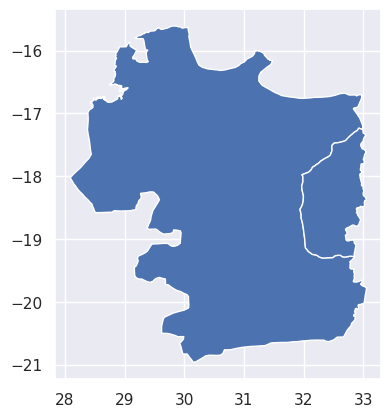

In [17]:
ethn_or = pd.concat([shona_or, manyika_or])
ethn_or.plot()

## Reproject everything to same projection

In [18]:
buffer_or['NAM_LABEL'] = 'Buffer zone (100 km)'
border_or['NAM_LABEL'] = 'Shona-Mankiya Border'

In [19]:
buffer_or_wgs84 = buffer_or.to_crs(shona_or.crs) 
border_or_wgs84 = border_or.to_crs(shona_or.crs) 

In [20]:
border_or_wgs84_buf = border_or_wgs84.copy()
border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)

/tmp/ipykernel_2027644/3197058390.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)


## Replicate Figure 1 
### No code provided for comparison, we do not know the underlying projection
### Basic map, we do not make nice legend

In [21]:
extent = pd.DataFrame([ethn_or.total_bounds,
                       buffer_or_wgs84.total_bounds,
                       border_or_wgs84.total_bounds,
                      ], columns=['xmin', 'ymin', 'xmax', 'ymax'])
xmin = extent['xmin'].min() - 1
ymin = extent['ymin'].min() - 1
xmax = extent['xmax'].max() + 1
ymax = extent['ymax'].max() + 1
extent = [xmin, ymin, xmax, ymax]

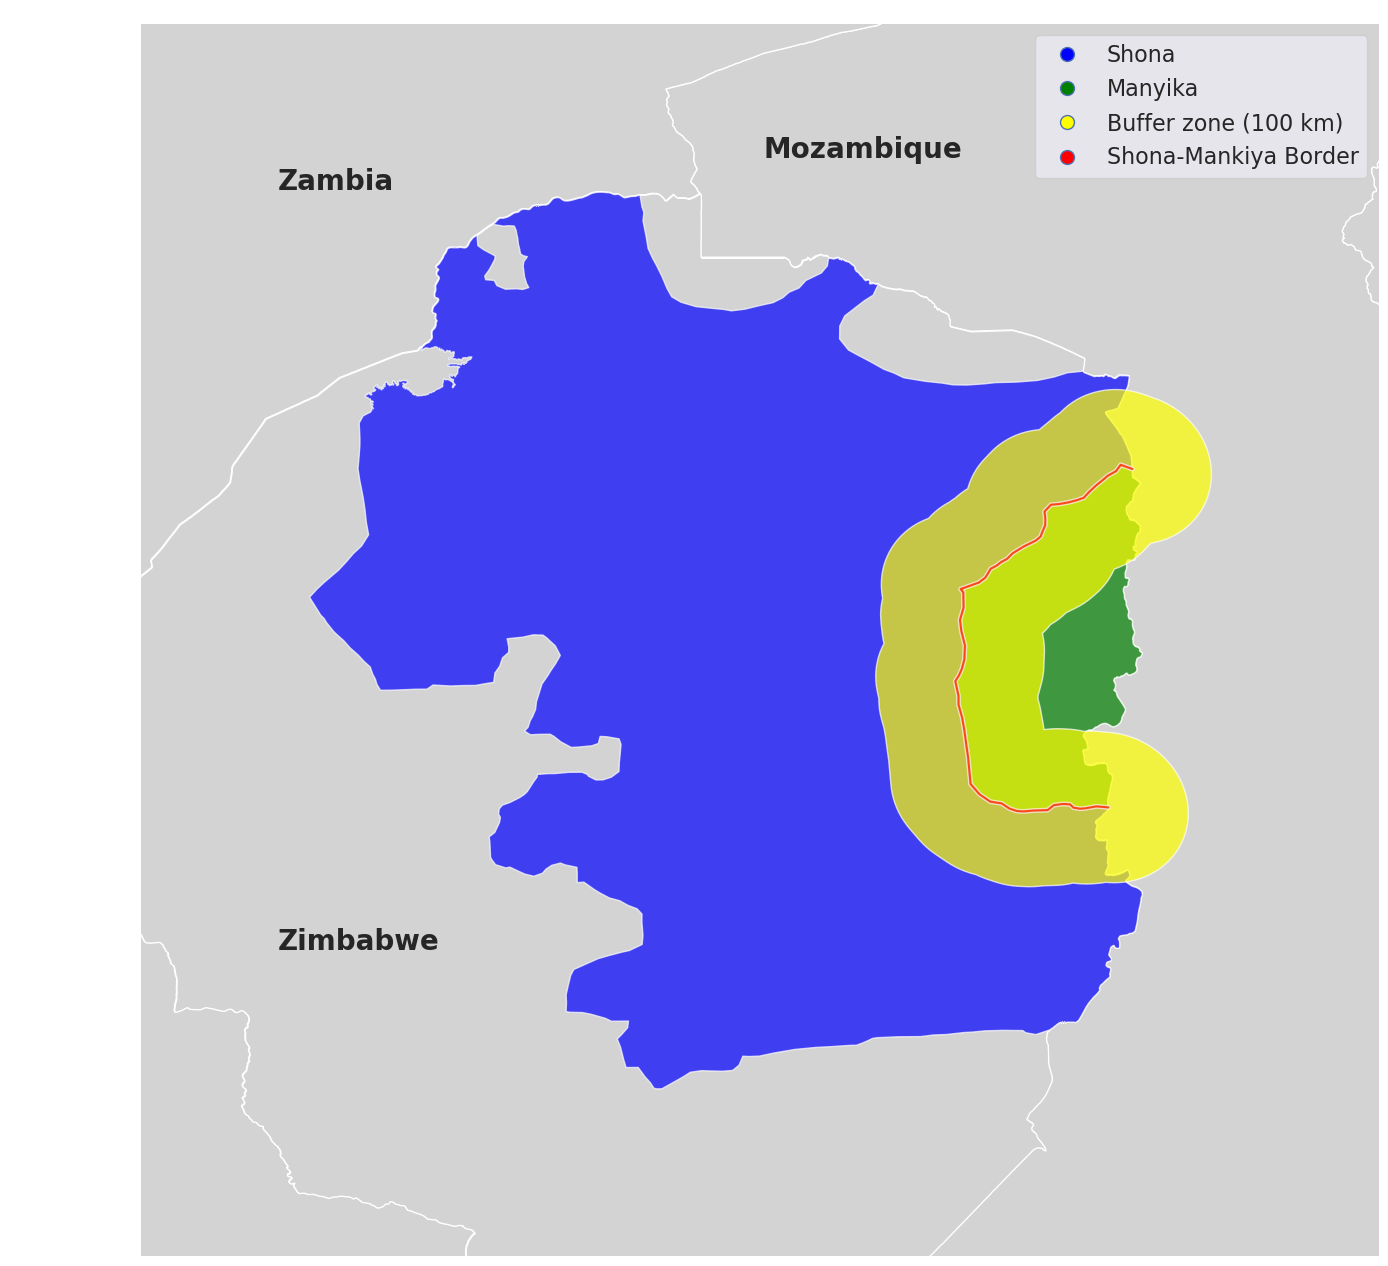

In [22]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([ethn_or, buffer_or_wgs84, border_or_wgs84_buf]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

Text(0.55, 0.875, 'Mozambique')

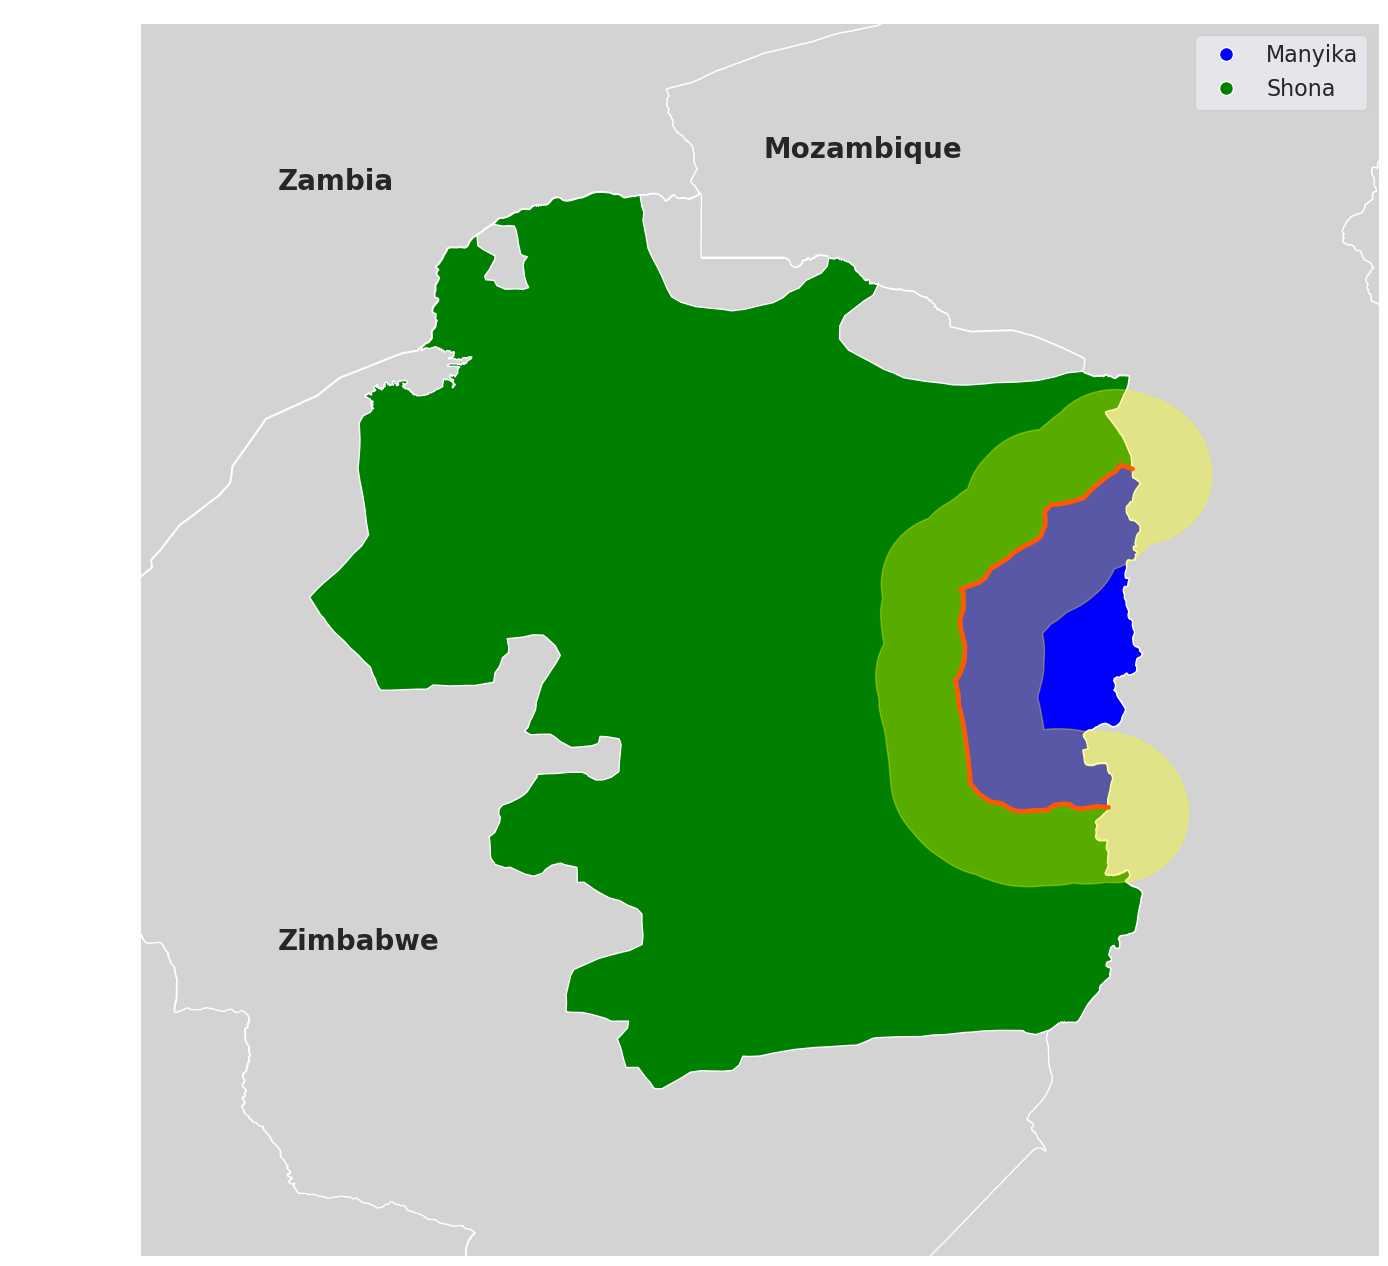

In [23]:
cmap = mpl.colors.ListedColormap(['blue', 'green'])
ax = gplt.choropleth(
        ethn_or, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        #ax=ax,
        rasterized=True,
    )
gplt.choropleth(
        border_or_wgs84_buf, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='red', linewidth=1,
        #legend=True,
        color='red', alpha=1,
        #figsize=(24, 16),
        ax=ax,
        extent=extent,
    )
gplt.choropleth(
        buffer_or_wgs84, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='yellow', linewidth=1,
        #legend=True,
        color='yellow', alpha=0.35,
        ax=ax
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
#plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

<div class="alert alert-block alert-info", >
    <center><H1>Main Replication</H1>
</div>

<div class="alert alert-block alert-info", >
    <center><H1>New Data</H1>
</div>

# Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
## Import data & reproject to CEA

In [24]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno = ethno.to_crs(cea)
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,"116,000,000 in Russian Federation (2002 census)",116000000,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,"215,000,000 in United States (2000 census)",215000000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,"MULTIPOLYGON (((-75.11965 19.97388, -75.11741 ..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,"163,000,000 in Brazil (1998)",163000000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,"17,400,000 in Australia (2006)",17400000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,"MULTIPOLYGON (((147.36099 -43.08758, 147.36375..."
4,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [25]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [26]:
ethno.shape

(7327, 19)

# Replicate figure with new data

In [27]:
shona = ethno.loc[(ethno['NAM_LABEL']=='Shona') & (ethno['ID']=='SNA-ZWE')].reset_index()
shona

,index,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,87,SNA-ZWE,sna-ZWE,sna-zw,sna-ZI,Shona,Shona,SHONA,Shona,Africa,Zimbabwe,"10,700,000 in Zimbabwe",10700000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,sna,"POLYGON ((29.90175 -15.62221, 29.90864 -15.623..."


In [28]:
manyika = ethno.loc[(ethno['NAM_LABEL']=='Manyika') & (ethno['ID']=='MXC-ZWE')].reset_index()
manyika

,index,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,671,MXC-ZWE,mxc-ZWE,mxc-zw,mxc-ZI,Manyika,Manyika,MANYIKA,Manyika,Africa,Zimbabwe,"861,000 in Zimbabwe (2000 WCD)",861000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,mxc,"POLYGON ((32.99626 -17.25993, 32.99637 -17.265..."


In [29]:
manyika = manyika.to_crs(cea)
shona = shona.to_crs(cea)
mspair = manyika.merge(shona, how='cross', suffixes=['_1', '_2'])
mspair[['ID_1', 'ID_2']]

,ID_1,ID_2
0,MXC-ZWE,SNA-ZWE


In [30]:
mspair['buffer_2'] = mspair.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1)
mspair['buffer_1'] = mspair.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1)

<Axes: >

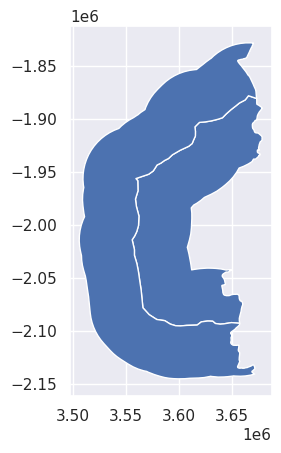

In [31]:
msbuffer = gp.GeoDataFrame(pd.concat([mspair[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), mspair[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
msbuffer.plot()

In [32]:
msbuffer

,ID_1,ID_2,geometry
0,MXC-ZWE,SNA-ZWE,"POLYGON ((3673115.504 -1936845.334, 3671744.96..."
0,MXC-ZWE,SNA-ZWE,"POLYGON ((3506812.186 -2025072.249, 3505930.19..."


In [33]:
msbuffer['NAM_LABEL'] = ['Mankiya Buffer zone (50 km)', 'Shona Buffer zone (50 km)']
msbuffer

,ID_1,ID_2,geometry,NAM_LABEL
0,MXC-ZWE,SNA-ZWE,"POLYGON ((3673115.504 -1936845.334, 3671744.96...",Mankiya Buffer zone (50 km)
0,MXC-ZWE,SNA-ZWE,"POLYGON ((3506812.186 -2025072.249, 3505930.19...",Shona Buffer zone (50 km)


In [34]:
border =  Borders(manyika, shona)
border['NAM_LABEL'] = 'Shona-Mankiya Border'
border

/tmp/ipykernel_2027644/4057681547.py:7: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)


,__idx1,__idx2,index_1,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,geometry,NAM_LABEL
0,0,0,671,MXC-ZWE,mxc-ZWE,mxc-zw,mxc-ZI,Manyika,Manyika,MANYIKA,...,"10,700,000 in Zimbabwe",10700000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,sna,"MULTILINESTRING ((3657136.373 -2092750.927, 36...",Shona-Mankiya Border


In [35]:
shona = shona.to_crs(wgs84)
manyika = manyika.to_crs(wgs84)
border = border.to_crs(wgs84)
msbuffer = msbuffer.to_crs(wgs84)

Text(0.55, 0.875, 'Mozambique')

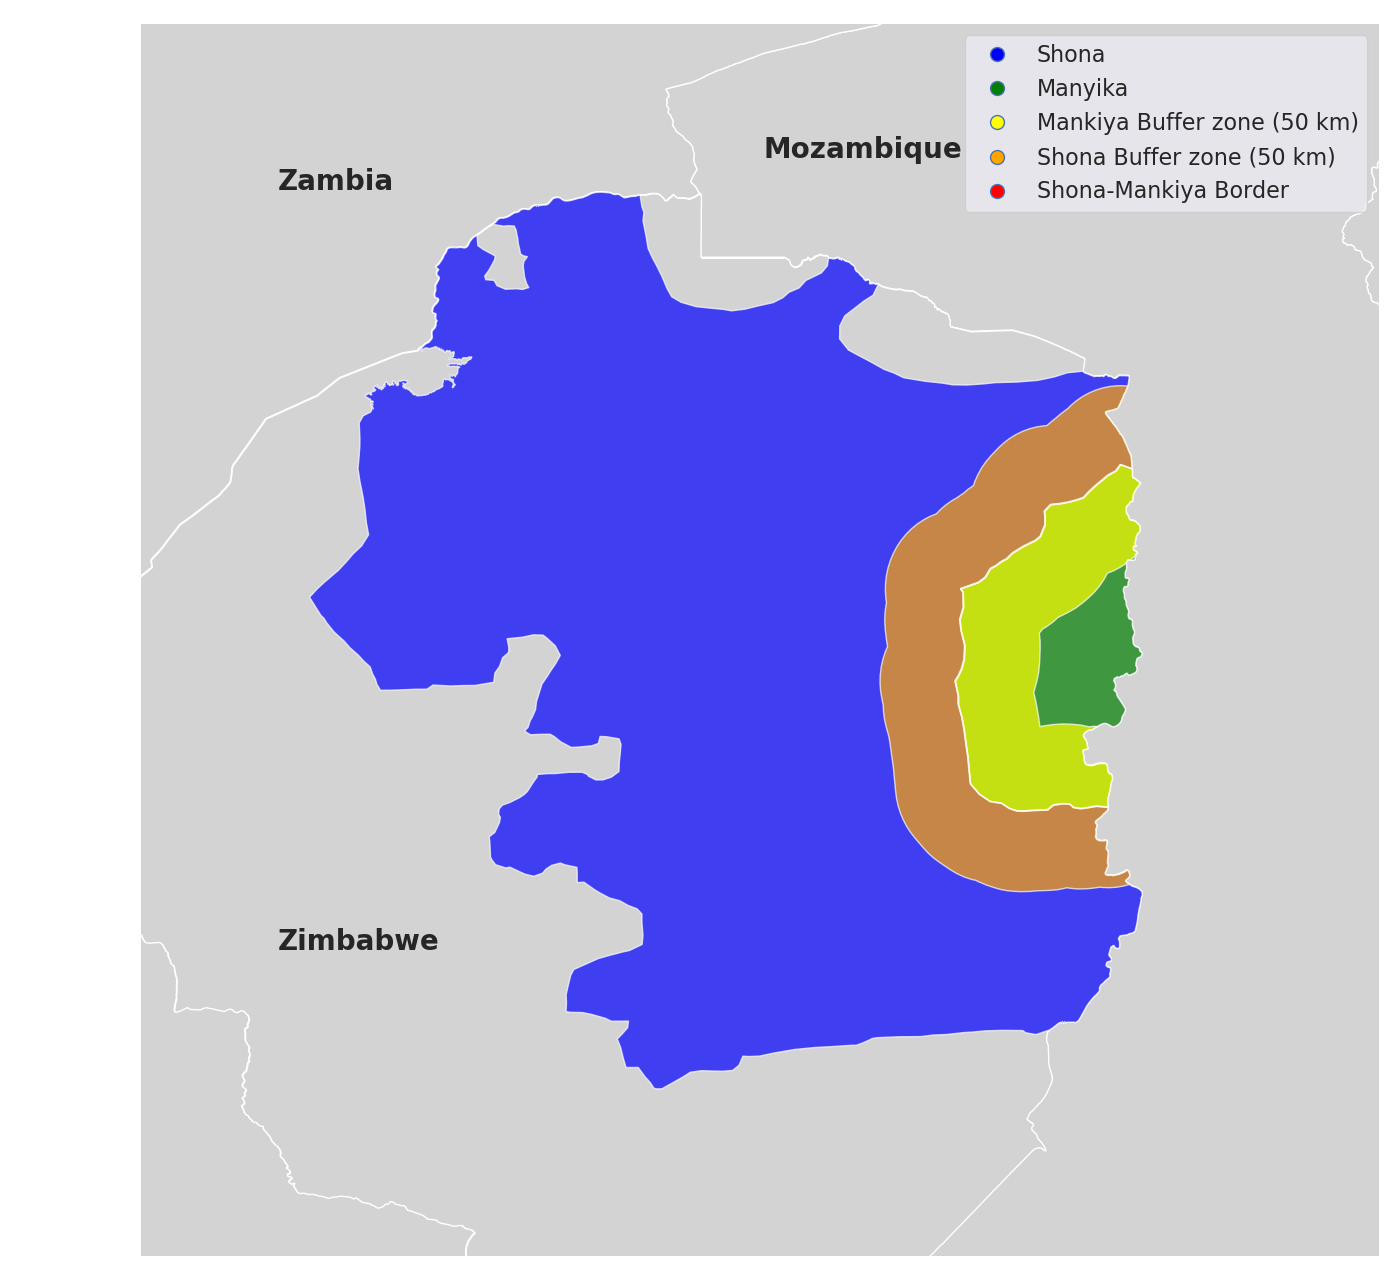

In [36]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
dfmap = pd.concat([shona, manyika, msbuffer, border]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
# plt.savefig(pathgraphs + 'figure-1-updated-data-alt-buffer.pdf', dpi=300, bbox_inches='tight')

# Create borders and buffers using full dataset from Ethnologue 16 edition

# Find duplicated languages x country
## Is this what Dickens calls the groups occupy non-adjacent regions of a country (fn7)?

In [37]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry


## Create all pairs of languages/countries

In [38]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()
print(nb_cpus)

import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()
client

128


/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40227 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40227/status,
Dashboard: http://127.0.0.1:40227/status,Workers: 4
Total threads: 8,Total memory: 501.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42641,Workers: 4
Dashboard: http://127.0.0.1:40227/status,Total threads: 8
Started: Just now,Total memory: 501.00 GiB
Comm: tcp://127.0.0.1:40405,Total threads: 2
Dashboard: http://127.0.0.1:41303/status,Memory: 125.25 GiB
Nanny: tcp://127.0.0.1:37695,


In [39]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)

In [40]:
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/core.py:7175: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [41]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 67.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.

In [42]:
pairs.shape

(74396, 38)

In [43]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [44]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,CNT_2,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr


In [45]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_1', right_on='ID', suffixes=['', "_1"])
pairs.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_1
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"121,000,000 in Japan (1985)",121000000,Japonic,L,Japonic,JAPONIC,Japan,jpn,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,JPN-JPN,jpn-JPN,jpn-jp,jpn-JA,Japanese,Japanese,JAPANESE,Japanese,Asia,Japan,...,"121,000,000 in Japan (1985)",121000000,Japonic,L,Japonic,JAPONIC,Japan,jpn,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
3,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,KHK-MNG,"POLYGON ((101.05564 51.29117, 101.03179 51.136..."


In [46]:
pairs['geometry'] = pairs['geometry_1'].values
pairs[['ID_1', 'ID', 'geometry', 'geometry_1']].head()

,ID_1,ID,geometry,geometry_1
0,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43...","MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43...","MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
3,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,KHK-MNG,"POLYGON ((101.05564 51.29117, 101.03179 51.136...","POLYGON ((101.05564 51.29117, 101.03179 51.136..."


In [47]:
pairs = pairs.drop(columns=['ID', 'geometry_1'])

In [48]:
pairs = pairs.to_crs(cea)

In [49]:
pairs = pairs.merge(ethno[['ID', 'geometry']].to_crs(cea), how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((5022045.912 4345314.017, 50171...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((14944468.315 3612072.777, 1494...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((5022045.912 4345314.017, 50171...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((12095297.711 2069921.530, 1209...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((11249462.721 4957243.443, 11246807.3...","MULTIPOLYGON (((12095297.711 2069921.530, 1209..."


In [50]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 0 ns, sys: 28 µs, total: 28 µs
Wall time: 37.2 µs


(67069, 40)

In [51]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


## We have dropped all same pair language/countries, now let's IDENTIFY all same langauge pairs that are in differenct countries
## e.g., SPA-MEX and SPA-GTM
## special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes
## Not clear there is a reason for different ISO code, so we also drop them
### (see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

## This differs from Dickens, he seems to keep these

In [52]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2
419,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,"4,670,000 in Guatemala (1995)",4670000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,SPA-GTM,"MULTIPOLYGON (((-10157007.858 1687135.375, -10..."


In [53]:
# pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
# pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)

## JUST IDENTIFY THESE THAT HAVE THE SAME LANGUAGE IN DIFFERENT COUNTRIES LIKE MEXICO AND GUATEMALA
pairs["same_lang"] = pairs.duplicated(subset=['NAME2_1', 'NAME2_2'], keep=False)

pairs.shape

(67069, 41)

In [56]:
pairs[['ID_1','ID_2']].to_stata(proot + 'alt_before_non_repeated.dta', version=117)

In [54]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 0 ns, sys: 12 µs, total: 12 µs
Wall time: 21 µs


In [55]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
36527,SBH-PNG,LIB-PNG
36528,DJE-BFA,HAU-BFA
36529,BHE-PAK,AEQ-PAK
36530,AEQ-PAK,BHE-PAK


In [ ]:
non_repeated_pairs.to_stata(proot + 'or_after_non_repeated.dta', version=117)

In [56]:
pairs2 = pairs.loc[(pairs.ID_1=='ENG-USA')&(pairs.ID_2=='SPA-MEX')].reset_index()
pairs2[['ID_1', 'ID_2', 'geometry_1', 'geometry_2']]
pairs2['buffer_2'] = pairs2.apply(lambda x: x.geometry_1.buffer(buffer_size_radius_km * 1000).intersection(x.geometry_2), axis=1)
pairs2['buffer_1'] = pairs2.apply(lambda x: x.geometry_2.buffer(buffer_size_radius_km * 1000).intersection(x.geometry_1), axis=1)

<Axes: >

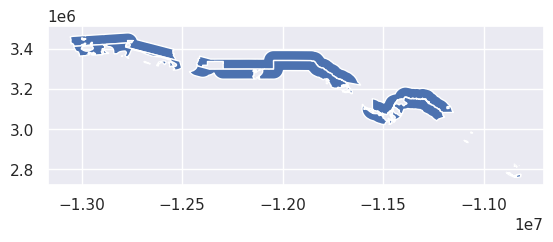

In [57]:
pairs3 = gp.GeoDataFrame(pd.concat([pairs2[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), pairs2[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
pairs3.plot()

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Buffers</H1>
</div>

In [58]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=20)

In [ ]:
%time
ddpairs['buffer_2'] = ddpairs.apply(lambda x: x.geometry_1.buffer(buffer_size_radius_km * 1000).intersection(x.geometry_2), axis=1, meta=(None, 'geometry'))
ddpairs['buffer_1'] = ddpairs.apply(lambda x: x.geometry_2.buffer(buffer_size_radius_km * 1000).intersection(x.geometry_1), axis=1, meta=(None, 'geometry'))
#borders = ddpairs.compute(scheduler="threads", num_workers=120)
buffers = ddpairs.compute()

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 17.9 µs


/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 2.13 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
buffers[['ID_1', 'ID_2', 'buffer_1', 'buffer_2']]

In [ ]:
buffers['identifier'] = buffers['ID_1'] + '-' + buffers['ID_2']

In [ ]:
buffers1_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_1']], crs=cea, geometry='buffer_1')
buffers1_geo.head()

In [ ]:
buffers2_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_2']], crs=cea, geometry='buffer_2')
buffers2_geo.head()

In [ ]:
buffers1_geo.to_file(pathout + 'ethnologue_buffers_alt1_v16'+ str(buffer_size_radius_km) +'.json', driver="GeoJSON")
buffers2_geo.to_file(pathout + 'ethnologue_buffers_alt2_v16'+ str(buffer_size_radius_km) +'.json', driver="GeoJSON")

## No need to recreate overlap etc, we can use what we created in [Replication-Construct-Buffers-Touch-v16.ipynb](./Replication-Construct-Buffers-Touch-v16.ipynb)

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Spatial Stats for New Buffers</H1>
</div>

In [6]:
buffers1_geo = gp.read_file(pathout + 'ethnologue_buffers_alt1_v16'+ str(buffer_size_radius_km) +'.json', driver="GeoJSON")
buffers2_geo = gp.read_file(pathout + 'ethnologue_buffers_alt2_v16'+ str(buffer_size_radius_km) +'.json', driver="GeoJSON")

# Work with CSI data to compute spatial statistics

In [14]:
CSI = os.listdir(proot + 'CSI')

In [15]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [16]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

In [ ]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers1_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)    
    # Compute stats for second section of buffer    
    out= csi.stats(buffers2_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt2.dta', version=117, write_index=False)

In [ ]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt.dta')   
    out1 = out1.set_index(['identifier', 'ID_1', 'ID_2'])
    out2 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt2.dta')
    out2 = out2.set_index(['identifier', 'ID_1', 'ID_2'])
    out.append((out1[out1.columns] - out2[out1.columns]).abs())

In [ ]:
out = pd.concat(out, axis=1)

In [ ]:
out.to_stata(proot + 'Dickens_AltBuf_v16_absdif_'+ str(buffer_size_radius_km)+'.dta', version=117)

# Work with CSI specific crops

In [7]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

In [8]:
CSI_crops = os.listdir(proot + 'CSICrops')
CSI_crops.sort()
CSI_crops

['alfalfalo.tif',
 'bananalo.tif',
 'barleylo.tif',
 'buckwheatlo.tif',
 'cabbagelo.tif',
 'canarygrasslo.tif',
 'carrotlo.tif',
 'cassavalo.tif',
 'chickpealo.tif',
 'citruslo.tif',
 'coconutlo.tif',
 'coffeelo.tif',
 'cottonlo.tif',
 'cowpealo.tif',
 'drypealo.tif',
 'flaxlo.tif',
 'foxtailmilletlo.tif',
 'greengramlo.tif',
 'groundnutlo.tif',
 'gyamlo.tif',
 'indricelo.tif',
 'jatrophalo.tif',
 'maizelo.tif',
 'maizestrlo.tif',
 'maizetrhlo.tif',
 'maizetrllo.tif',
 'miscanthuslo.tif',
 'oatlo.tif',
 'oilpalmlo.tif',
 'olivelo.tif',
 'onionlo.tif',
 'pasturegrasseslo.tif',
 'pasturelegumeslo.tif',
 'pearlmilletlo.tif',
 'phaseolusbeanlo.tif',
 'pigeonpealo.tif',
 'pulseslo.tif',
 'rapelo.tif',
 'ryelo.tif',
 'sorghumlo.tif',
 'sorghumstrlo.tif',
 'sorghumtrhlo.tif',
 'sorghumtrllo.tif',
 'soybeanlo.tif',
 'springbarleylo.tif',
 'springryelo.tif',
 'springwheatlo.tif',
 'sugarbeetlo.tif',
 'sugarcanelo.tif',
 'sunflowerlo.tif',
 'sweetpotatolo.tif',
 'switchgrasslo.tif',
 'tealo.tif'

In [9]:
%%time
for r in CSI_crops:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSICrops/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers1_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)    
    # Compute stats for second section of buffer    
    out= csi.stats(buffers2_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt2.dta', version=117, write_index=False)

alfalfalo


/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
bananalo
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
barleylo
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
buckwheatlo
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
cabbagelo
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'std', 'max', 'median', 'mean', 'min'], dtype='object')
canarygrasslo
Index(['identifi

In [10]:
%%time
out = []
for r in CSI_crops:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt.dta')   
    out1 = out1.set_index(['identifier', 'ID_1', 'ID_2'])
    out2 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + r.replace('.tif', '') + '_alt2.dta')
    out2 = out2.set_index(['identifier', 'ID_1', 'ID_2'])
    out.append((out1[out1.columns] - out2[out1.columns]).abs())

alfalfalo
bananalo
barleylo
buckwheatlo
cabbagelo
canarygrasslo
carrotlo
cassavalo
chickpealo
citruslo
coconutlo
coffeelo
cottonlo
cowpealo
drypealo
flaxlo
foxtailmilletlo
greengramlo
groundnutlo
gyamlo
indricelo
jatrophalo
maizelo
maizestrlo
maizetrhlo
maizetrllo
miscanthuslo
oatlo
oilpalmlo
olivelo
onionlo
pasturegrasseslo
pasturelegumeslo
pearlmilletlo
phaseolusbeanlo
pigeonpealo
pulseslo
rapelo
ryelo
sorghumlo
sorghumstrlo
sorghumtrhlo
sorghumtrllo
soybeanlo
springbarleylo
springryelo
springwheatlo
sugarbeetlo
sugarcanelo
sunflowerlo
sweetpotatolo
switchgrasslo
tealo
tobaccolo
tomatolo
wetricelo
wheatlo
whitepotatolo
whiteyamlo
winterbarleylo
winterryelo
winterwheatlo
yamslo
CPU times: user 17 s, sys: 514 ms, total: 17.5 s
Wall time: 21.4 s


In [11]:
out = pd.concat(out, axis=1)

In [12]:
out.to_stata(proot + 'Dickens_AltBuf_v16_crops_absdif_'+str(buffer_size_radius_km)+'.dta', version=117)